In [12]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

%matplotlib inline

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sunghwanki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sunghwanki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Load and check data
### 2.1 Load data

In [2]:
# Load train and Test set
train = pd.read_csv('../3_spooky-author-identification/data/train.csv')
test = pd.read_csv('../3_spooky-author-identification/data/test.csv')

In [3]:
# Check the data set
print("Train data : ", train.shape)
print("Test  data : ", test.shape)

Train data :  (19579, 3)
Test  data :  (8392, 2)


In [4]:
# Check the train data set's columns
print("Train data columns Qty :", len(train.columns), "\n\n")
print("Train data columns :", train.columns)

Train data columns Qty : 3 


Train data columns : Index(['id', 'text', 'author'], dtype='object')


In [5]:
# Classify by author
EAP = train[train['author']=='EAP']
MWS = train[train['author']=='MWS']
HPL = train[train['author']=='HPL']

In [8]:
stemmer = SnowballStemmer('english')

def text_to_words( text ):

    # Convert non-English characters to spaces
    letters_only = re.sub('[^a-zA-Z]', ' ', text)
    
    # Lowercase conversion
    words = letters_only.lower().split()
    
    # Convert stopwords to sets.
    stops = set(stopwords.words('english'))
    
    # Remove Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    
    # Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    
    # Combining with a space-delimited string
    return( ' '.join(stemming_words) )

In [9]:
# Get the total number of text data
train_num_text = train['text'].size
EAP_num_text = EAP['text'].size
MWS_num_text = MWS['text'].size
HPL_num_text = HPL['text'].size

print(train_num_text, EAP_num_text,MWS_num_text,HPL_num_text)

19579 7900 6044 5635


In [10]:
# Improved workflow processing speed
from multiprocessing import Pool

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # Get workers parameter from keyword item
    workers = kwargs.pop('workers')
    
    # Define a process pool with the number of workers
    pool = Pool(processes=workers)
    
    # Work by dividing the number of functions and data frames 
    # to be executed by the number of workers
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    
    # Combine work
    return pd.concat(list(result))

In [13]:
# Proprocessing text data in a train
train_clean = apply_by_multiprocessing(train['text'], text_to_words, workers=4)

# Proprocessing text data by author
EAP_clean = apply_by_multiprocessing(EAP['text'], text_to_words, workers=4)
MWS_clean = apply_by_multiprocessing(MWS['text'], text_to_words, workers=4)
HPL_clean = apply_by_multiprocessing(HPL['text'], text_to_words, workers=4)


In [14]:
EAP_clean.head(3)

0    process howev afford mean ascertain dimens dun...
2    left hand gold snuff box caper hill cut manner...
6    astronom perhap point took refug suggest non l...
Name: text, dtype: object

### Word cloud
- A visualization method that can be used when you have the frequency of words data
- The importance of each word is shown with font size or color
- This format is useful for quickly perceiving the most prominent terms and for locating a term alphabetically to determine its relative prominence

In [15]:
def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600 ):
    wordcloud = WordCloud(stopwords = STOPWORDS, 
                          background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

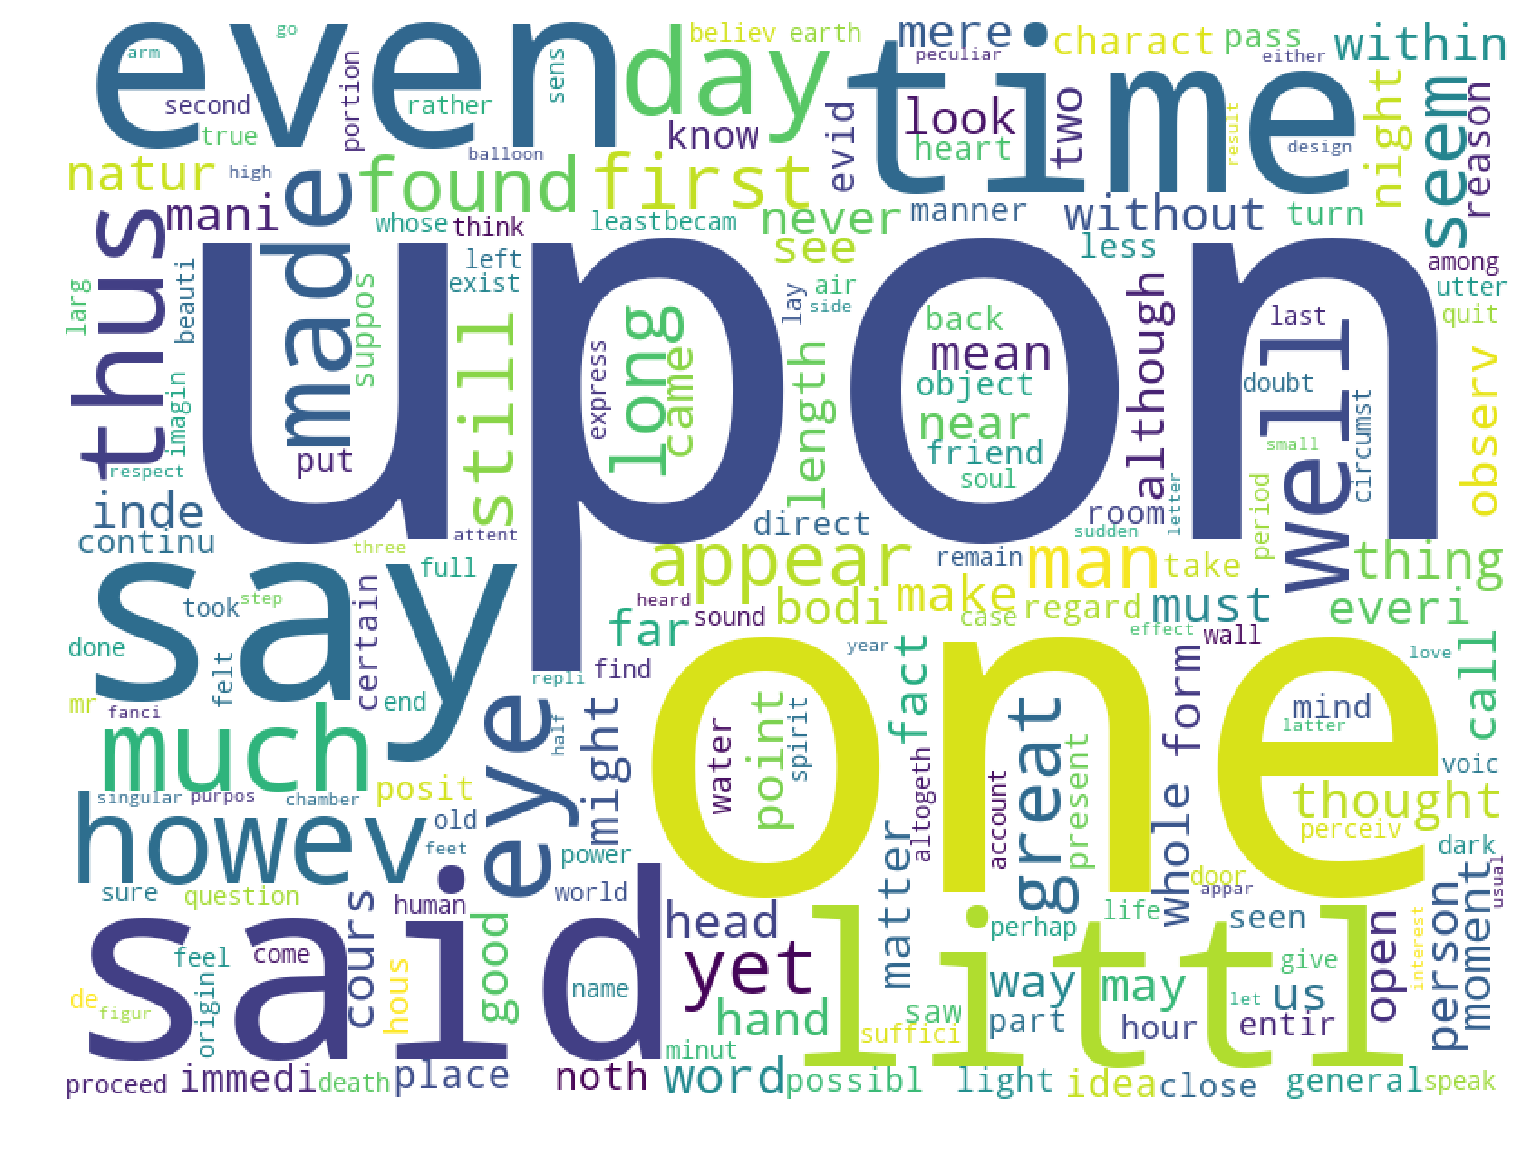

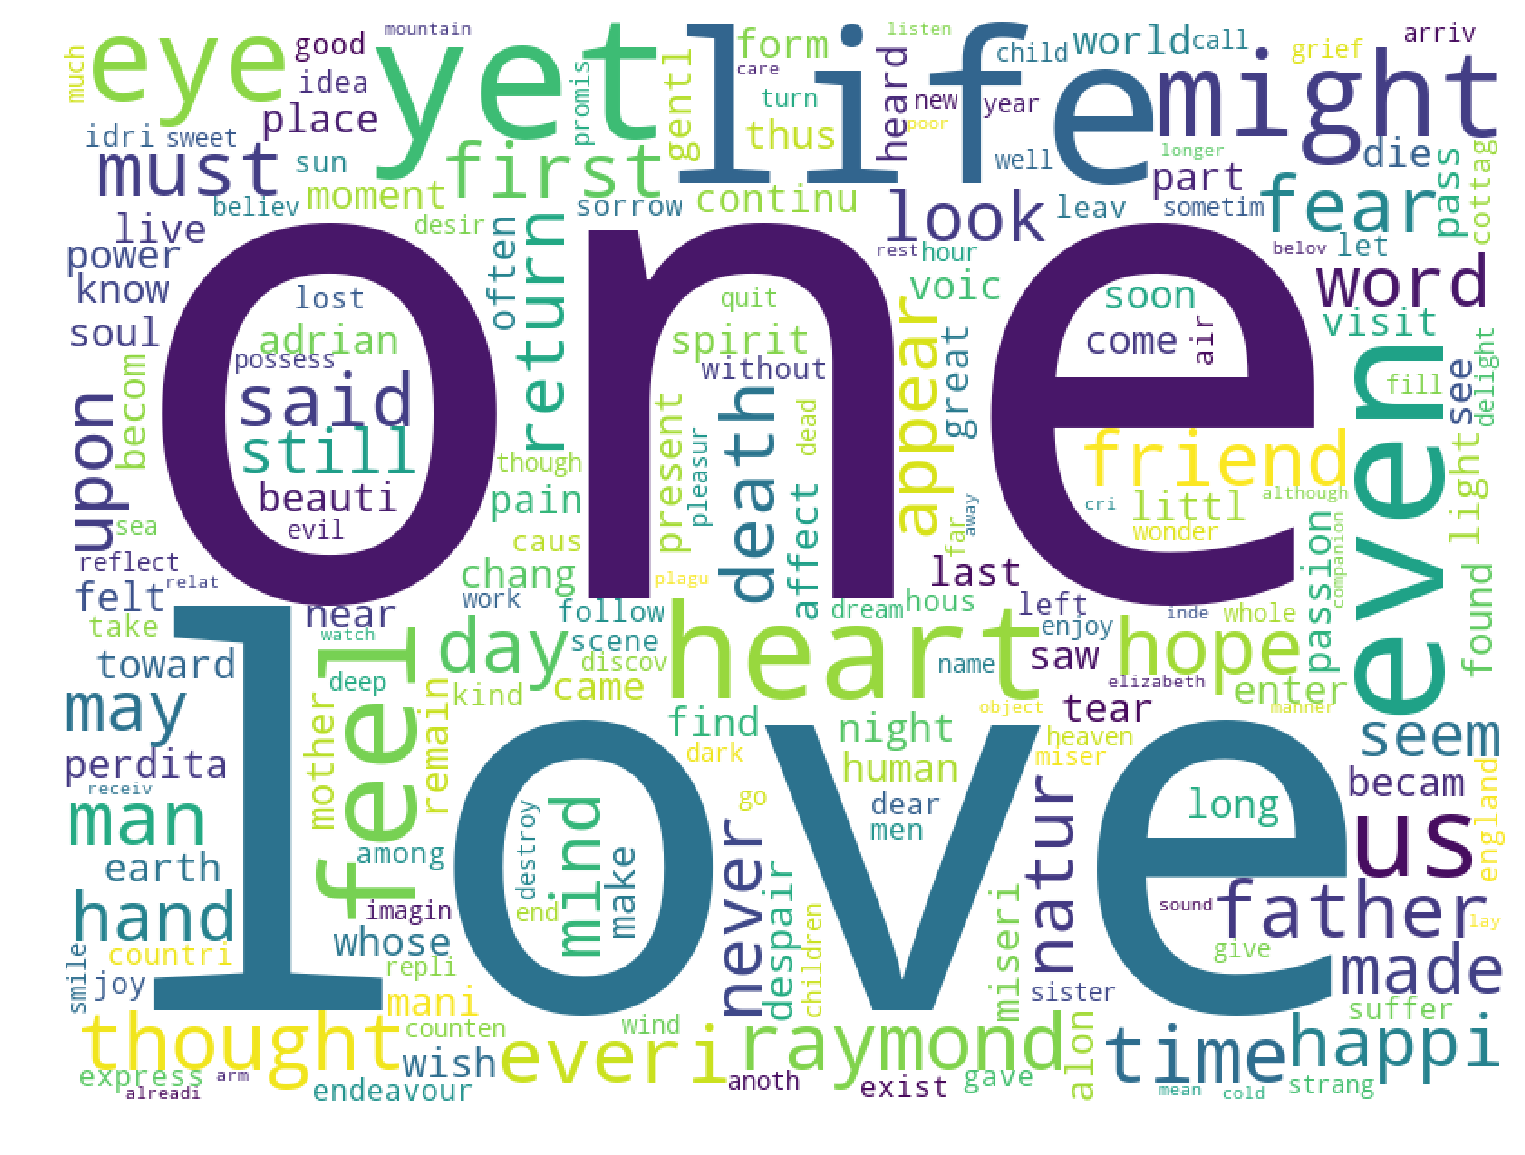

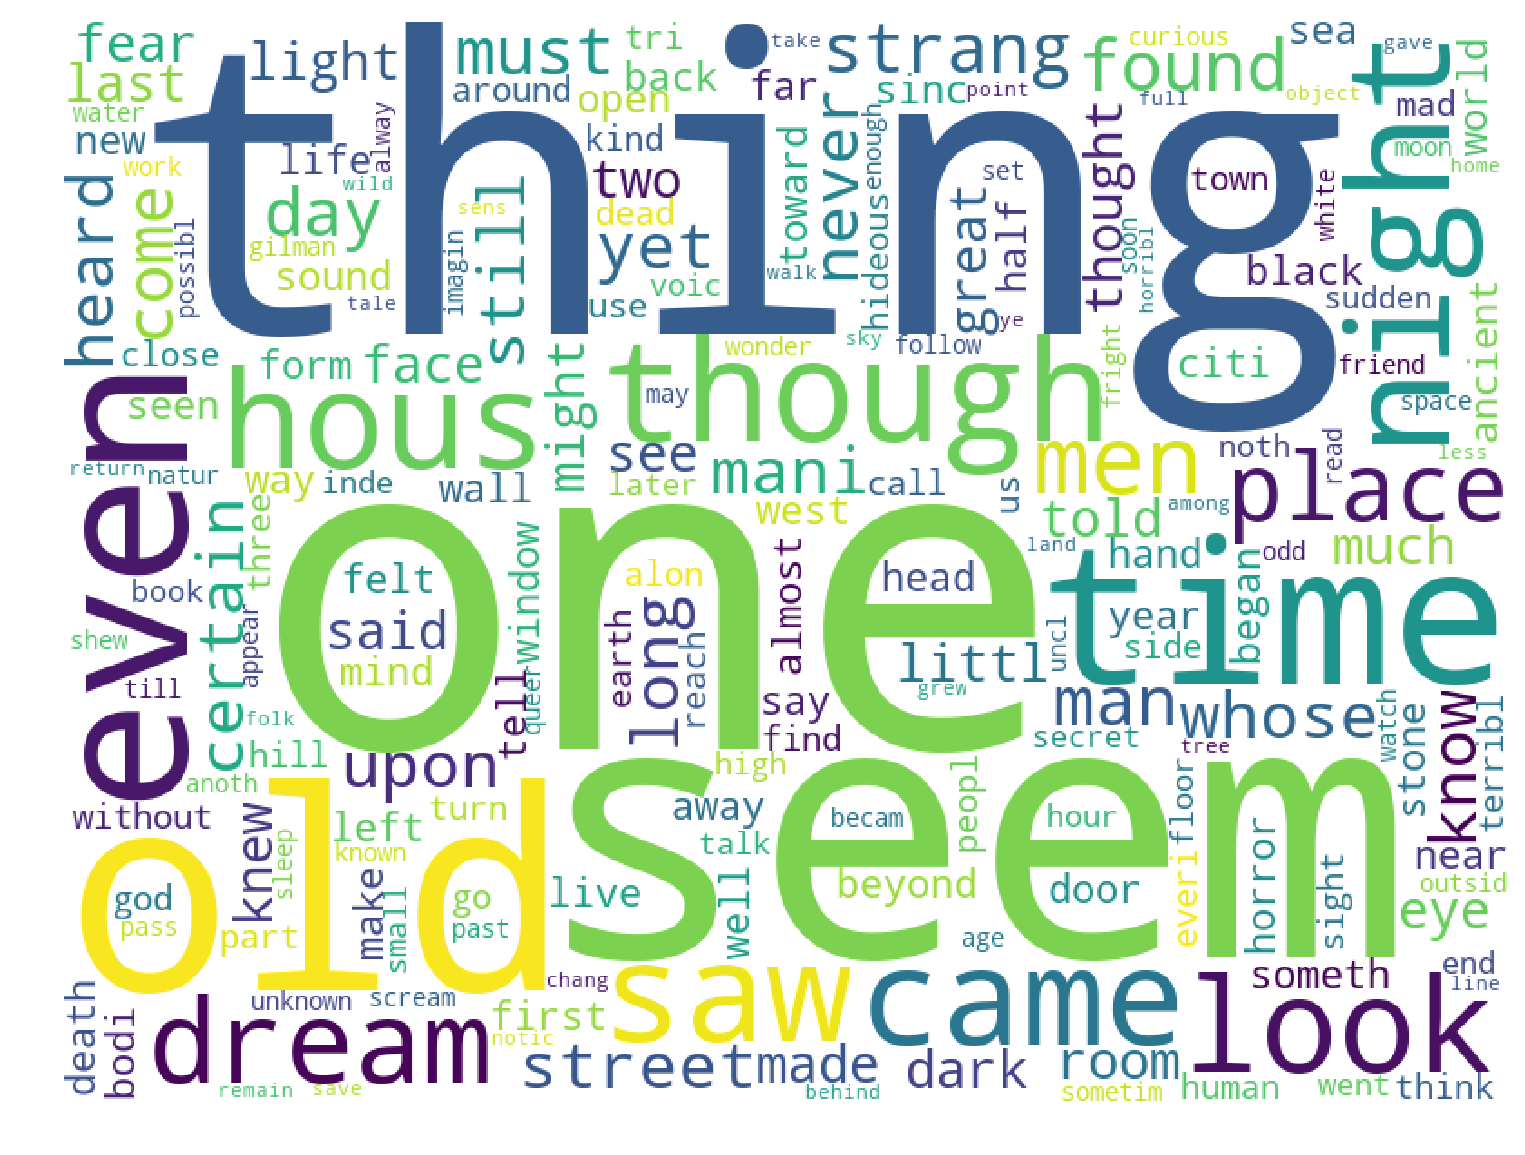

In [16]:
# Draw a word cloud for every word of author-specific data.
displayWordCloud(' '.join(EAP_clean))
displayWordCloud(' '.join(MWS_clean))
displayWordCloud(' '.join(HPL_clean))

In [17]:
# Number of words
train['num_words'] = train_clean.apply(lambda x: len(str(x).split()))

# Number of words without duplicates
train['num_uniq_words'] = train_clean.apply(lambda x: len(set(str(x).split())))

Average of number of words per text : 13.076612697277696
Median of number of words per text 11.0
Average of number of unique words per text: 12.723121712038408
Median of number of unique words per tex 11.0


Text(0.5,1,'Number of unique words distribution')

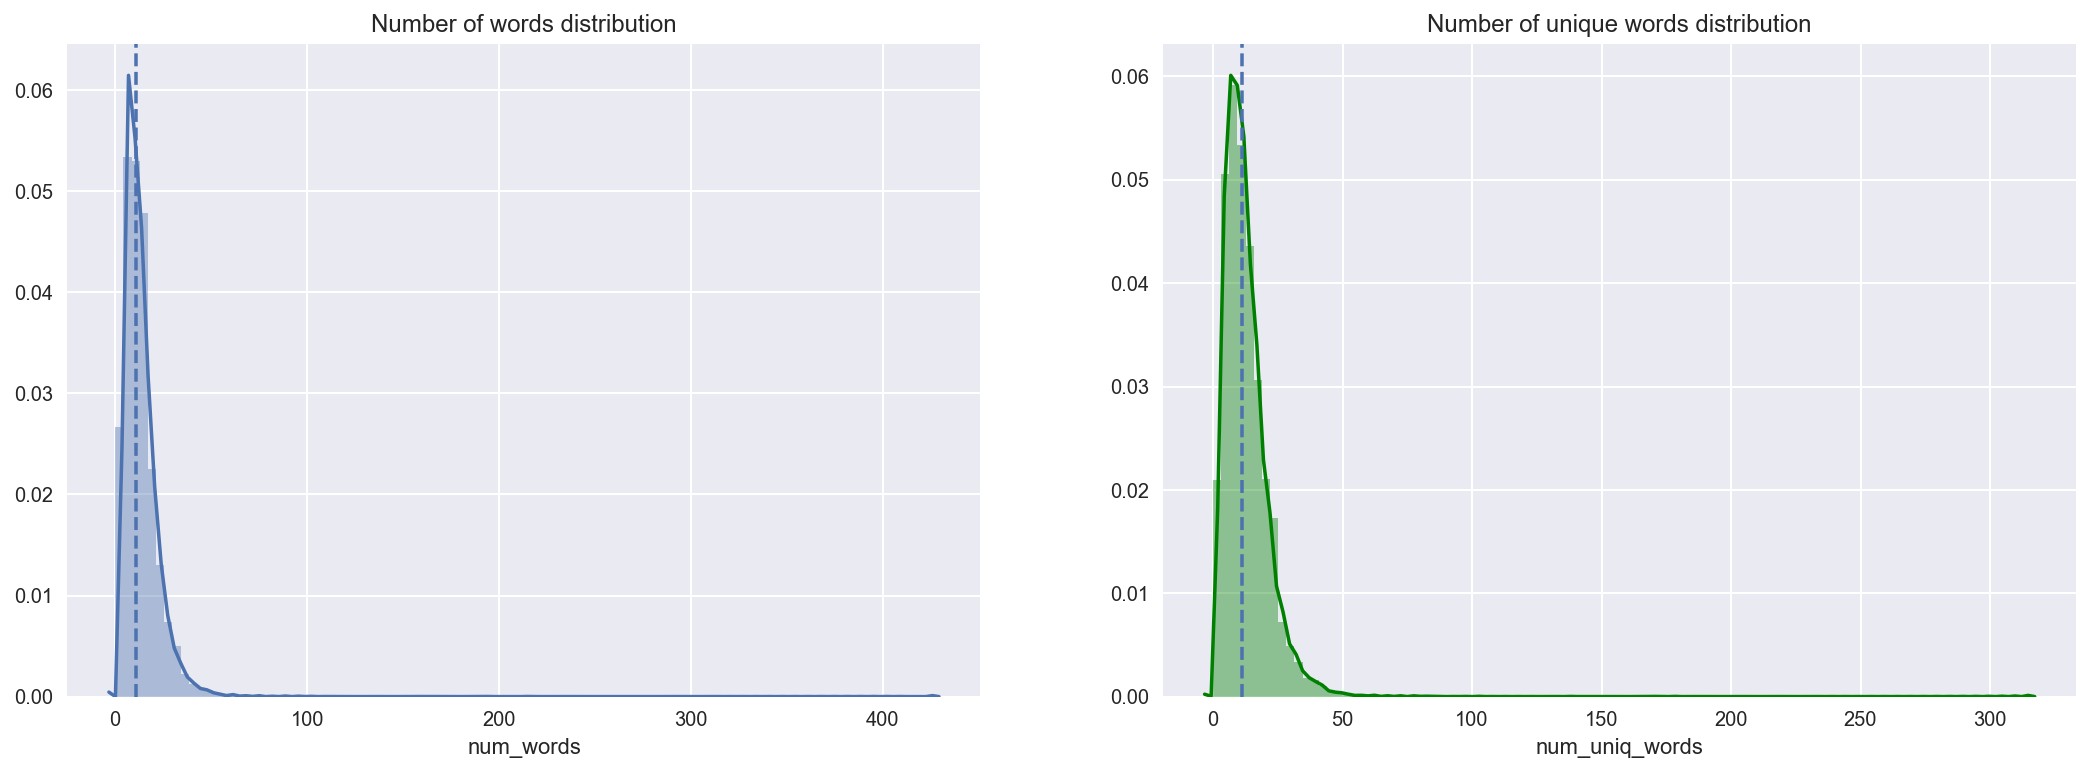

In [18]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18, 6)
print('Average of number of words per text :', train['num_words'].mean())
print('Median of number of words per text', train['num_words'].median())
sns.distplot(train['num_words'], bins=100, ax=axes[0])
axes[0].axvline(train['num_words'].median(), linestyle='dashed')
axes[0].set_title('Number of words distribution')

print('Average of number of unique words per text:', train['num_uniq_words'].mean())
print('Median of number of unique words per tex', train['num_uniq_words'].median())
sns.distplot(train['num_uniq_words'], bins=100, color='g', ax=axes[1])
axes[1].axvline(train['num_uniq_words'].median(), linestyle='dashed')
axes[1].set_title('Number of unique words distribution')

### Vectorization of data

#### CountVectorizer

* Convert a collection of text documents to a matrix of token counts
* Specify the minimum number of documents for which tokens will appear with min_df.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline


# Creating a vectorizer object
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, 
                             ngram_range=(1, 3),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [20]:
# Use pipelines to improve speed
pipeline = Pipeline([
    ('vect', vectorizer),
])  

In [38]:
# Convert train data to vector
X_train = pipeline.fit_transform(train_clean)
X_train

<19579x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 278739 stored elements in Compressed Sparse Row format>

In [39]:
# Check the shape of vectorized data
X_train.shape

(19579, 20000)

In [40]:
# Save the name of the column in the vocab variable
vocab = vectorizer.get_feature_names()

# Total number of words
sum_of_word = np.sum(X_train, axis=0)

# Check the total of each word
pd.DataFrame(sum_of_word, columns=vocab, index=['Total'])

,abandon,abaout,abat,abbey,abdic,abdul,abdul alhazr,abernethi,aberr,abey,...,zigzag,zigzag direct,zimmer,zit,zit still,zodiac,zodiac light,zokkar,zokkar olden,zone
Total,48,24,6,5,7,5,5,4,6,3,...,5,2,3,5,2,3,2,3,2,3


In [41]:
# Check vectorized features
pd.DataFrame(X_train[:10].toarray(), columns=vocab).head()

,abandon,abaout,abat,abbey,abdic,abdul,abdul alhazr,abernethi,aberr,abey,...,zigzag,zigzag direct,zimmer,zit,zit still,zodiac,zodiac light,zokkar,zokkar olden,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model

#### Prepare input data

In [61]:
y_train = train['author']

In [42]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(train['author'])
y_train = lb.transform(train['author'])

In [43]:
y_train[:5]

array([[1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0]])

### [Random forest](https://en.wikipedia.org/wiki/Random_forest)
The most important feature of Random Forest is that it consists of trees with slightly different characteristics due to randomness. This feature allows the prediction of each tree to be decorrelated, resulting in improved generalization performance. In addition, randomization makes the forest robust for data with noise.

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Setup the K-Fold
k_fold = KFold(n_splits=10, shuffle=True, random_state=2018)

# Use Random Forest Classifier
for max_depth in range(1,20):
    globals()['tree%s' % max_depth] = RandomForestClassifier(max_depth=max_depth, n_estimators=10).fit(X_train, y_train)
    print('{}_cross_val_scroe:{}'.format('tree%s' % max_depth, cross_val_score(globals()['tree%s' % max_depth],X_train, y_train, cv=k_fold, n_jobs=-1, scoring="accuracy").mean()))

tree1_cross_val_scroe:0.4070180223111503
tree2_cross_val_scroe:0.41554744681750594
tree3_cross_val_scroe:0.42065459472635097
tree4_cross_val_scroe:0.43097249704186485
tree5_cross_val_scroe:0.4387351029775515
tree6_cross_val_scroe:0.4470094780372492
tree7_cross_val_scroe:0.44935962311244354
tree8_cross_val_scroe:0.46580586282290914
tree9_cross_val_scroe:0.46948331935385035
tree10_cross_val_scroe:0.4811280633727281
tree11_cross_val_scroe:0.48679763537089304
tree12_cross_val_scroe:0.49267126258479677
tree13_cross_val_scroe:0.5021201490889675
tree14_cross_val_scroe:0.5093715078477355
tree15_cross_val_scroe:0.5076370515626313
tree16_cross_val_scroe:0.5138675340035481
tree17_cross_val_scroe:0.5213757168290879
tree18_cross_val_scroe:0.5317945376149001
tree19_cross_val_scroe:0.5364938099684587


In [63]:
# The performance is best when max_depth is 14
model_1 = RandomForestClassifier(max_depth=14, n_estimators=10).fit(X_train, y_train)

In [65]:
test_clean = apply_by_multiprocessing(test['text'], text_to_words, workers=4)

In [66]:
# Vectorize Test data
X_test = pipeline.transform(test_clean)

In [69]:
# Predict 
result = model_1.predict_proba(X_test)
result[:10]

array([[ 0.41324742,  0.27707104,  0.30968154],
       [ 0.42208296,  0.28186925,  0.29604778],
       [ 0.41009089,  0.33664068,  0.25326843],
       [ 0.42208296,  0.28186925,  0.29604778],
       [ 0.42208296,  0.28186925,  0.29604778],
       [ 0.42208296,  0.28186925,  0.29604778],
       [ 0.39739027,  0.35023711,  0.25237261],
       [ 0.42208296,  0.28186925,  0.29604778],
       [ 0.44840913,  0.2882574 ,  0.26333346],
       [ 0.42208296,  0.28186925,  0.29604778]])

In [70]:
pred = pd.DataFrame(result, columns=['EAP','HPL','MWS'])

In [71]:
submit = pd.DataFrame(test['id'])
submit = submit.join(pred)
submit.head()

,id,EAP,HPL,MWS
0,id02310,0.413247,0.277071,0.309682
1,id24541,0.422083,0.281869,0.296048
2,id00134,0.410091,0.336641,0.253268
3,id27757,0.422083,0.281869,0.296048
4,id04081,0.422083,0.281869,0.296048


In [73]:
# Export csv file
submit.to_csv("../3_spooky-author-identification/Submit/submission_"+str(score)+".csv".format(score=0.509371), index=False)

score : 1.01138
1073 / 1244 ( 86% )